In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from sklearn.model_selection import train_test_split

In [2]:
file_time_a = '../Time Development/Data/time_a.csv'
file_time_b_decay =  '../Time Development/Data/time_b_decay.csv'
file_time_b_normal = '../Time Development/Data/time_b_normal.csv'
file_time_b_growth = '../Time Development/Data/time_b_growth.csv'


time_a_df = pd.read_csv(file_time_a)
time_b_decay_df = pd.read_csv(file_time_b_decay)
time_b_growth_df = pd.read_csv(file_time_b_growth)
time_b_normal_df = pd.read_csv(file_time_b_normal)

if "Unnamed: 0" in time_a_df.columns:
    time_a_df.drop(columns=["Unnamed: 0"], inplace=True)
if "Unnamed: 0" in time_b_decay_df.columns:
    time_b_decay_df.drop(columns=["Unnamed: 0"], inplace=True)
if "Unnamed: 0" in time_b_growth_df.columns:
    time_b_growth_df.drop(columns=["Unnamed: 0"], inplace=True)
if "Unnamed: 0" in time_b_normal_df:
    time_b_normal_df.drop(columns=["Unnamed: 0"], inplace=True)

time_a_df["Date"] = pd.to_datetime(time_a_df["Date"])
time_b_decay_df["Date"] = pd.to_datetime(time_b_decay_df["Date"])
time_b_growth_df["Date"] = pd.to_datetime(time_b_growth_df["Date"])
time_b_normal_df["Date"] = pd.to_datetime(time_b_normal_df["Date"])

In [3]:
features = ["CTR", "Engagement"]

In [4]:
# Split Time A into 80% training and 20% testing
time_a_train, time_a_test = train_test_split(time_a_df, test_size=0.2, random_state=42, shuffle=True)

drift_threshold = .5

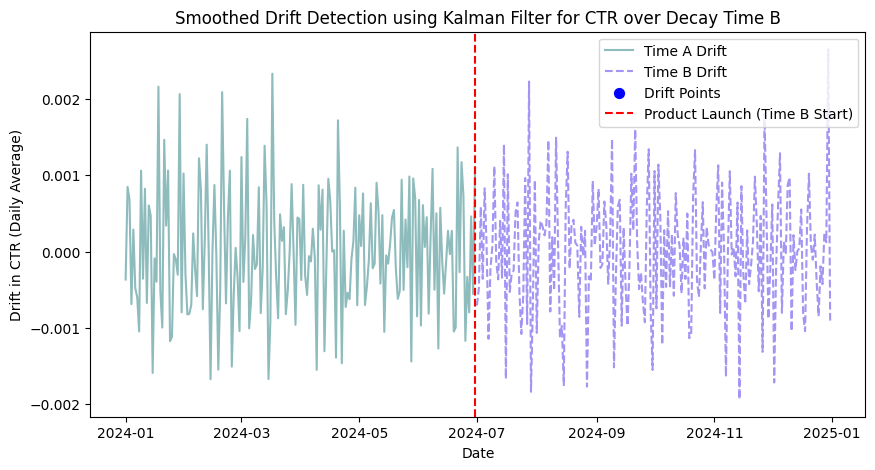

First Drift detected for Engagement on 2024-07-01 00:00:00 with deviation of 0.689886


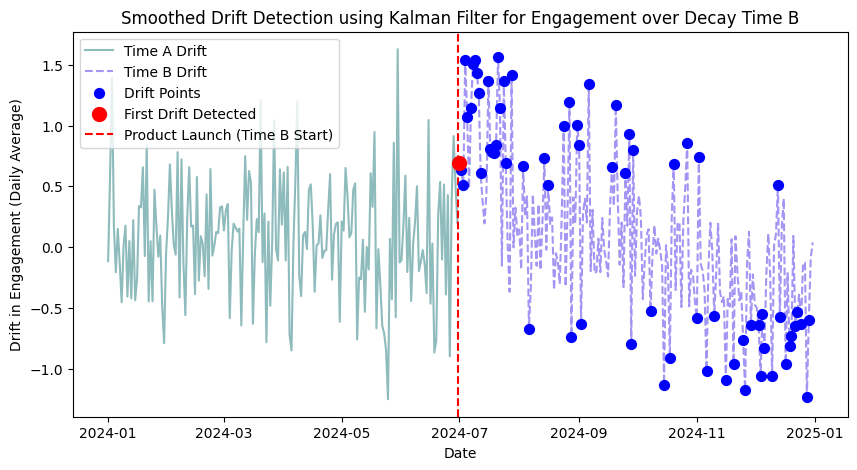

In [5]:
### DECAY TIME B ###
for feature in features:
    # Initialize Kalman Filter
    kf = KalmanFilter(initial_state_mean=np.mean(time_a_train[feature]), 
                      initial_state_covariance=1,
                      transition_matrices=[1], 
                      observation_matrices=[1],
                      observation_covariance=1,
                      transition_covariance=0.01) 

    # Train Kalman Filter on 80% of Time A (training set)
    kf = kf.em(time_a_train[feature].values, n_iter=10)

    # Apply Kalman Filter to all of Time A and Time B
    filtered_state_means_a, _ = kf.filter(time_a_df[feature].values)
    filtered_state_means_b, _ = kf.filter(time_b_decay_df[feature].values)

    # Compute Drift as (Actual - Predicted)
    drift_a = time_a_df[feature].values - filtered_state_means_a.flatten()
    drift_b = time_b_decay_df[feature].values - filtered_state_means_b.flatten()

    # Drift columns for Time A and Time B
    drift_a_df = pd.DataFrame({"Date": time_a_df["Date"], "Drift": drift_a})
    drift_b_df = pd.DataFrame({"Date": time_b_decay_df["Date"], "Drift": drift_b})

    # Compute daily average drift to reduce noise
    daily_drift_a = drift_a_df.groupby("Date")["Drift"].mean()
    daily_drift_b = drift_b_df.groupby("Date")["Drift"].mean()

    # Detect all points where drift exceeds threshold
    drift_indices = np.where(np.abs(daily_drift_b) > drift_threshold)[0]
    
    # Store detected drift points
    drift_dates = daily_drift_b.index[drift_indices]
    drift_values = daily_drift_b.iloc[drift_indices].values

    # Identify first detected drift event
    first_drift_date = None
    first_drift_value = None

    if len(drift_indices) > 0:
        first_drift_date = drift_dates[0]
        first_drift_value = drift_values[0]
        print(f"First Drift detected for {feature} on {first_drift_date} with deviation of {first_drift_value:.6f}")

    # Plot smoothed drift over time
    plt.figure(figsize=(10, 5))
    plt.plot(daily_drift_a.index, daily_drift_a, label="Time A Drift", alpha=0.7, color="cadetblue")
    plt.plot(daily_drift_b.index, daily_drift_b, label="Time B Drift", alpha=0.7, color="mediumslateblue", linestyle="dashed")
    
    # Mark all drift points
    plt.scatter(drift_dates, drift_values, color="blue", label="Drift Points", zorder=3, s=50)

    # Highlight first drift detection separately
    if first_drift_date:
        plt.scatter(first_drift_date, first_drift_value, color="red", label="First Drift Detected", zorder=3, s=100)

    # Mark product launch
    plt.axvline(x=time_a_df["Date"].iloc[-1], color="red", linestyle="--", label="Product Launch (Time B Start)")
    
    plt.xlabel("Date")
    plt.ylabel(f"Drift in {feature} (Daily Average)")
    plt.title(f"Smoothed Drift Detection using Kalman Filter for {feature} over Decay Time B")
    plt.legend()
    plt.show()

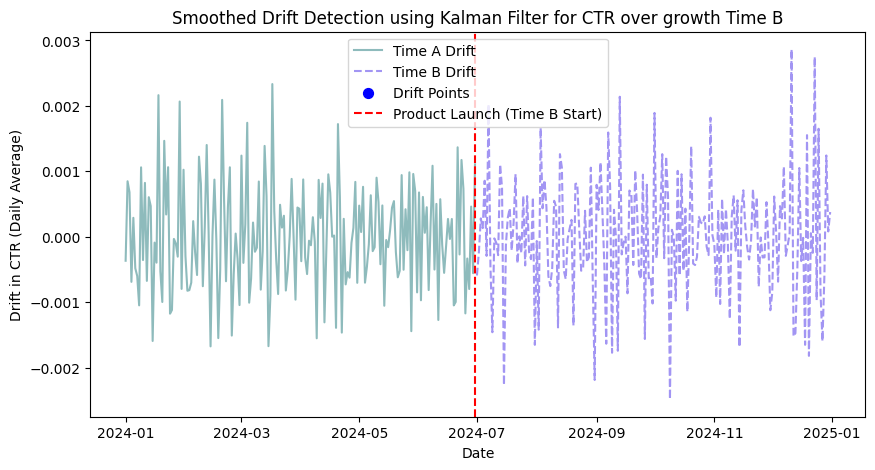

First Drift detected for Engagement on 2024-07-03 00:00:00 with deviation of -1.287657


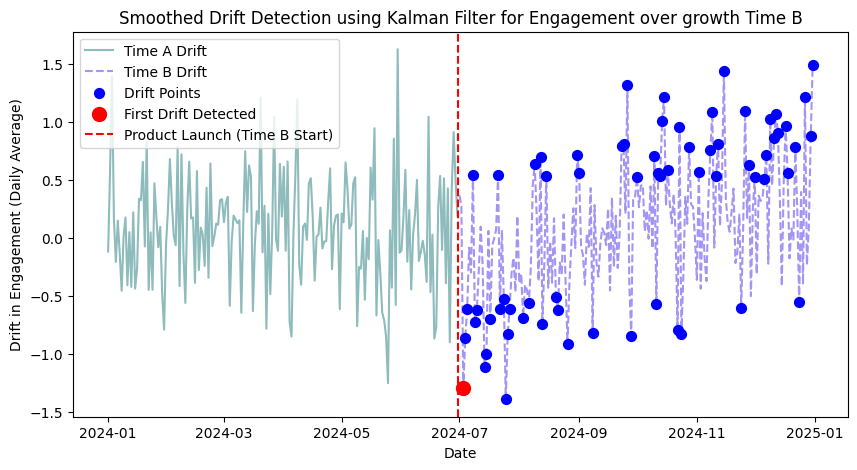

In [6]:
### GRWOTH TIME B ###

for feature in features:
    kf = KalmanFilter(initial_state_mean=np.mean(time_a_train[feature]), 
                      initial_state_covariance=1,
                      transition_matrices=[1], 
                      observation_matrices=[1],
                      observation_covariance=1,
                      transition_covariance=0.01) 

    kf = kf.em(time_a_train[feature].values, n_iter=10)

    filtered_state_means_a, _ = kf.filter(time_a_df[feature].values)
    filtered_state_means_b, _ = kf.filter(time_b_growth_df[feature].values)

    drift_a = time_a_df[feature].values - filtered_state_means_a.flatten()
    drift_b = time_b_growth_df[feature].values - filtered_state_means_b.flatten()

    drift_a_df = pd.DataFrame({"Date": time_a_df["Date"], "Drift": drift_a})
    drift_b_df = pd.DataFrame({"Date": time_b_growth_df["Date"], "Drift": drift_b})

    daily_drift_a = drift_a_df.groupby("Date")["Drift"].mean()
    daily_drift_b = drift_b_df.groupby("Date")["Drift"].mean()

    drift_indices = np.where(np.abs(daily_drift_b) > drift_threshold)[0]
    
    drift_dates = daily_drift_b.index[drift_indices]
    drift_values = daily_drift_b.iloc[drift_indices].values

    first_drift_date = None
    first_drift_value = None

    if len(drift_indices) > 0:
        first_drift_date = drift_dates[0]
        first_drift_value = drift_values[0]
        print(f"First Drift detected for {feature} on {first_drift_date} with deviation of {first_drift_value:.6f}")
        
    plt.figure(figsize=(10, 5))
    plt.plot(daily_drift_a.index, daily_drift_a, label="Time A Drift", alpha=0.7, color="cadetblue")
    plt.plot(daily_drift_b.index, daily_drift_b, label="Time B Drift", alpha=0.7, color="mediumslateblue", linestyle="dashed")
    plt.scatter(drift_dates, drift_values, color="blue", label="Drift Points", zorder=3, s=50)
    if first_drift_date:
        plt.scatter(first_drift_date, first_drift_value, color="red", label="First Drift Detected", zorder=3, s=100)
    plt.axvline(x=time_a_df["Date"].iloc[-1], color="red", linestyle="--", label="Product Launch (Time B Start)")
    plt.xlabel("Date")
    plt.ylabel(f"Drift in {feature} (Daily Average)")
    plt.title(f"Smoothed Drift Detection using Kalman Filter for {feature} over growth Time B")
    plt.legend()
    plt.show()

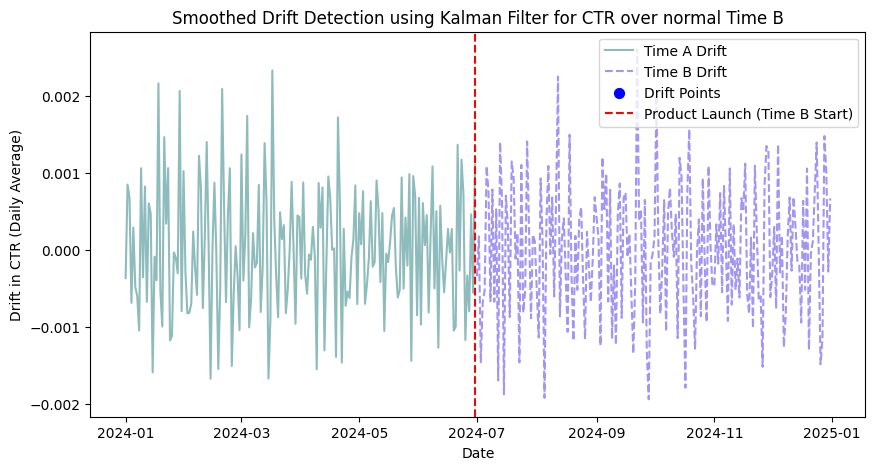

First Drift detected for Engagement on 2024-07-01 00:00:00 with deviation of 0.558932


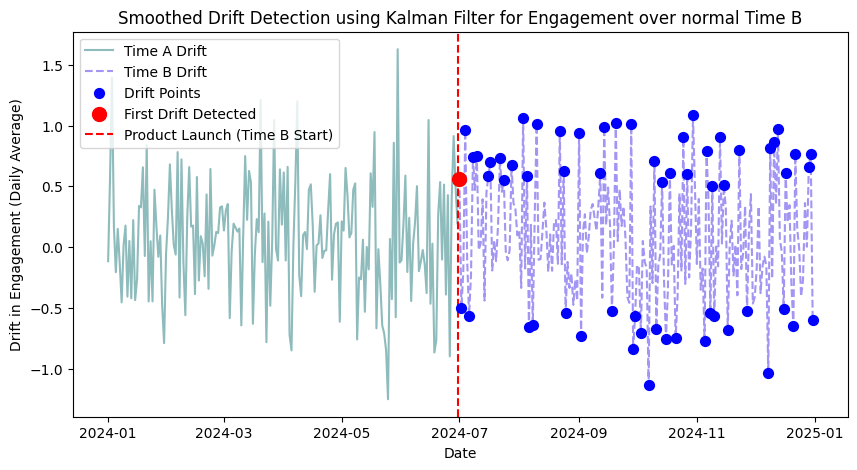

In [7]:
### NORMAL TIME B ###

for feature in features:
    kf = KalmanFilter(initial_state_mean=np.mean(time_a_train[feature]), 
                      initial_state_covariance=1,
                      transition_matrices=[1], 
                      observation_matrices=[1],
                      observation_covariance=1,
                      transition_covariance=0.01) 

    kf = kf.em(time_a_train[feature].values, n_iter=10)

    filtered_state_means_a, _ = kf.filter(time_a_df[feature].values)
    filtered_state_means_b, _ = kf.filter(time_b_normal_df[feature].values)

    drift_a = time_a_df[feature].values - filtered_state_means_a.flatten()
    drift_b = time_b_normal_df[feature].values - filtered_state_means_b.flatten()

    drift_a_df = pd.DataFrame({"Date": time_a_df["Date"], "Drift": drift_a})
    drift_b_df = pd.DataFrame({"Date": time_b_normal_df["Date"], "Drift": drift_b})

    daily_drift_a = drift_a_df.groupby("Date")["Drift"].mean()
    daily_drift_b = drift_b_df.groupby("Date")["Drift"].mean()

    drift_indices = np.where(np.abs(daily_drift_b) > drift_threshold)[0]
    
    drift_dates = daily_drift_b.index[drift_indices]
    drift_values = daily_drift_b.iloc[drift_indices].values

    first_drift_date = None
    first_drift_value = None

    if len(drift_indices) > 0:
        first_drift_date = drift_dates[0]
        first_drift_value = drift_values[0]
        print(f"First Drift detected for {feature} on {first_drift_date} with deviation of {first_drift_value:.6f}")

    plt.figure(figsize=(10, 5))
    plt.plot(daily_drift_a.index, daily_drift_a, label="Time A Drift", alpha=0.7, color="cadetblue")
    plt.plot(daily_drift_b.index, daily_drift_b, label="Time B Drift", alpha=0.7, color="mediumslateblue", linestyle="dashed")
    plt.scatter(drift_dates, drift_values, color="blue", label="Drift Points", zorder=3, s=50)
    if first_drift_date:
        plt.scatter(first_drift_date, first_drift_value, color="red", label="First Drift Detected", zorder=3, s=100)
    plt.axvline(x=time_a_df["Date"].iloc[-1], color="red", linestyle="--", label="Product Launch (Time B Start)")
    plt.xlabel("Date")
    plt.ylabel(f"Drift in {feature} (Daily Average)")
    plt.title(f"Smoothed Drift Detection using Kalman Filter for {feature} over normal Time B")
    plt.legend()
    plt.show()